# Notebook with analyses to predict gender from MRI data
In this notebook, we evaluate different strategies to deal with confounds (here: brain-size) when predicting psychological variables (here: gender) in a between-subject MVPA setting. 

### First some imports

In [1]:
import os.path as op
import sklearn.externals.joblib as jl
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import seaborn as sns
import scipy.stats as stats
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', context='poster')
rc = {"font.size":25, "axes.titlesize":25, "axes.labelsize":25, 
      "legend.fontsize":15, "xtick.labelsize": 15,
      "ytick.labelsize": 15, "text.usetex": True}

## ToDo
- plot distributions corr(voxels, brainsize)
- alleen confound regression op train (niks met test)
- checken LOO - wat gebeurt er met TBSS?

### Loading in the data
Below we load in the behavioral data (`PIOP1_behav_2017_with_brainsize.tsv`), which includes our factor-to-decode, "Gender", and our confound-of-interest ("brain_size"). The voxel patterns are contained in the `Mvp` objects - a data-structure defined in the [skbold](skbold.readthedocs.io) package - in the attribute `X`. Two sets of voxel patterns are loaded: one with VBM data (processed with the standard FSL-VBM pipeline) and one with skeletonized FA-data (processed with the standard FSL-TBSS pipeline) for a total of 217 subjects.

In [4]:
base_dir = '/media/lukas/goliath/MVCA/data/mvp'
behav_file = op.join(base_dir, 'PIOP1_behav_2017_with_brainsize.tsv')

# Load in VBM-mvp ...
mvp_vbm = jl.load(op.join(base_dir, 'mvp_vbm.jl'))

# ... and add "Gender" as "y" attribute
mvp_vbm.add_y(behav_file, col_name='Gender', index_col=0, nan_strategy='remove')
mvp_vbm.y = 1 - (mvp_vbm.y - 1)  # recode from [2, 1] to [0, 1] 
print("Shape of VBM voxel patterns: %s" % (mvp_vbm.X.shape,))

# Same for TBSS
mvp_tbss = jl.load(op.join(base_dir, 'mvp_tbss.jl'))
mvp_tbss.add_y(behav_file, col_name='Gender', index_col=0, nan_strategy='remove')
mvp_tbss.y -= 1
print("Shape of TBSS voxel patterns: %s" % (mvp_tbss.X.shape,))

Shape of VBM voxel patterns: (217, 412473)
Shape of TBSS voxel patterns: (217, 128340)


Note that the TBSS Mvp contains way fewer voxels due to the fact that `skbold` already removed all 0 voxels (i.e. voxels outside the TBSS skeleton). 

Now, we load in the confound - brain size - from the same file with "behavioral" data:

In [5]:
df = pd.read_csv(behav_file, index_col=0, sep='\t')
confound_vbm = df.loc[mvp_vbm.common_subjects]['brain_size']
confound_tbss = df.loc[mvp_tbss.common_subjects]['brain_size']

### Setting analysis parameters
For the first couple of confound strategies (here we call them "scenarios"), we set some default parameters for our MVPA pipelines.

In [6]:
n_folds = 10  # used in stratified K-fold
n_jobs = 8    # for parallel execution of pipelines through joblib

# Make a dict of both Mvps
mvp = {'vbm': mvp_vbm,
       'tbss': mvp_tbss}

# ... same for confounds (although they're the same here)
confound = {'vbm': confound_vbm[:, np.newaxis],
            'tbss': confound_tbss[:, np.newaxis]}

# We're going to evaluate the scenarios for different amounts of voxels
num_vox = np.round(np.logspace(2, 5, num=8)).astype(int)

# We'll use F1-score as an evaluation metric because our classes
# might be slightly imbalanced
metric = 'f1_macro'

# The default pipeline we'll use
pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=None)),
                     ('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

## Sanity check: does brain-size predict gender?
Before anything else, we need to evaluate whether brain-size is truly a confound?
In other words, does brain-size really predict gender? First, let's just simply calculate the correlation between brain-size and gender (or, formally: their point biserial correlation):

In [7]:
corr = np.corrcoef(np.squeeze(confound['vbm']), mvp['vbm'].y)
print("Correlation between brain-size and gender: %.3f" % corr[0, 1])

Correlation between brain-size and gender: 0.645


Indeed, there seems to be a strong statistical dependence between brain-size and gender (0 = female, 1 = male)! But how does this dependence manifest itself in a "decoding" setting (i.e. cross-validated machine learning analysis)? Let's find out:

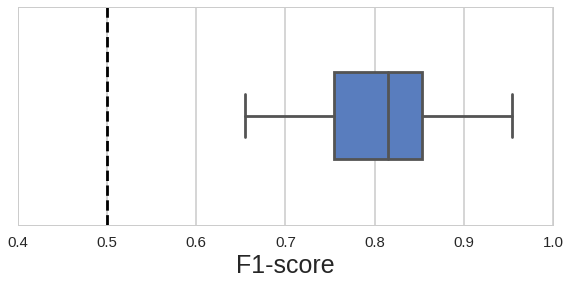

In [8]:
pipeline_check = Pipeline([('scaler', StandardScaler()),
                           ('clf', SVC(kernel='linear'))])

# Confound and y are the same for VBM & TBSS
this_mvp, this_confound = mvp['vbm'], confound['vbm']
scores = cross_val_score(pipeline_check, this_confound, this_mvp.y,
                         cv=n_folds, scoring=metric, n_jobs=n_jobs)
results_check = {'scores': scores}
df_check = pd.DataFrame(results_check)

with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.boxplot(df_check['scores'], width=0.4, orient='h', palette="muted")
    g.set(xlim=(.4, 1), xlabel='F1-score')
    plt.axvline(x=0.5, c='black', ls='dashed')
    plt.savefig('figures/f1_brainsize_gender2.pdf', transparent=True, bbox_inches='tight')
    plt.show()

Conclusion: yes, very accurately so (F1 > 0.8).

***
Note: we leave out the SelectKBest selector from our pipeline, since we only have one predictor/feature, namely brain-size.

## Distribution of correlation between voxels and gender & voxels and brain-size
Now, it might be informative to check the dependence between our voxels (in both the VBM and TBSS) and gender, just to get an intuition on how the distribution of correlations looks like. This kind of amounts to a mass-univariate analysis. But, importantly, we also quickly take a look at how this distribution changes when we account for brain-size (that is, we regress brain-size out of each feature/voxel). Later in this notebook, we elaborate more on this method!

In [9]:
mvp_no_brainsize = {}
        
for modality in ['vbm', 'tbss']:
    design = np.hstack((np.ones((mvp[modality].X.shape[0], 1)),
                        confound[modality]))

    tmp = deepcopy(mvp[modality])
    
    for vox in range(mvp[modality].X.shape[1]):
        beta = np.linalg.lstsq(design, mvp[modality].X[:, vox])[0]
        tmp.X[:, vox] -= beta.dot(design.T) 
    mvp_no_brainsize[modality] = tmp

In [10]:
corrs_X_y = {'corr': [], 'type': [], 'modality': []}

for modality in ['vbm', 'tbss']:
    
    for vox in range(mvp[modality].X.shape[1]):
        corrs_X_y['corr'].append(np.corrcoef(mvp[modality].X[:, vox], mvp[modality].y)[0, 1])
        corrs_X_y['type'].append('original')
        corrs_X_y['modality'].append(modality.upper())
        corrs_X_y['corr'].append(np.corrcoef(mvp_no_brainsize[modality].X[:, vox], mvp[modality].y)[0, 1])
        corrs_X_y['type'].append('corrected')
        corrs_X_y['modality'].append(modality.upper())

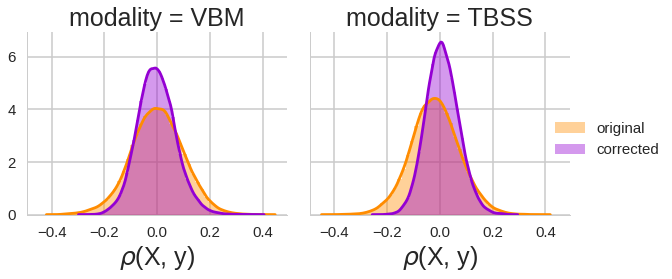

In [11]:
corr_df = pd.DataFrame(corrs_X_y)

with sns.plotting_context(rc=rc):
    colorpalette = dict(original="darkorange", corrected="darkviolet")
    g = sns.FacetGrid(corr_df, col='modality', hue='type', legend_out=True, size=5, palette=colorpalette)
    g = g.map(sns.distplot, "corr")
    g.add_legend(title='')
    g.set(xlabel=r'$\rho$(X, y)')
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    plt.savefig('figures/corr_X_gender.pdf', transparent=True, bbox_inches='tight')
    plt.show()

Moreover, let's check out the dependence between the voxels and brainsize:

In [15]:
corrs_X_c = {'corr': [], 'modality': []}

for modality in ['vbm', 'tbss']:
    
    for vox in range(mvp[modality].X.shape[1]):
        corrs_X_c['corr'].append(np.corrcoef(mvp[modality].X[:, vox], confound[modality].squeeze())[0, 1])
        corrs_X_c['modality'].append(modality.upper())

Let's check out what the average correlation is:

In [48]:
corr_df_X_c = pd.DataFrame(corrs_X_c)
corr_df_X_c.to_csv('correlations_X_with_brainsize.tsv', sep='\t')

abs_df = corr_df_X_c.copy()
abs_df['corr'] = abs_df['corr'].apply(np.abs)
abs_df.groupby('modality').describe()

corr                                                        \
             count      mean       std           min       25%       50%   
modality                                                                   
TBSS      128340.0  0.083207  0.063034  8.155205e-07  0.033116  0.070526   
VBM       412473.0  0.094734  0.075351  5.797967e-09  0.036159  0.077218   

                              
               75%       max  
modality                      
TBSS      0.119273  0.449613  
VBM       0.134748  0.469915

And plot it:

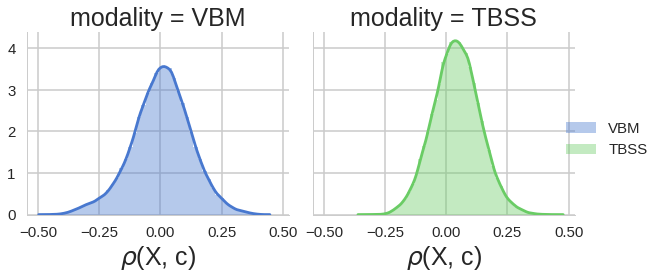

In [49]:
with sns.plotting_context(rc=rc):
    g = sns.FacetGrid(corr_df_X_c, col='modality', hue='modality', legend_out=True, size=5, palette="muted")
    g = g.map(sns.distplot, "corr")
    g.add_legend(title='')
    g.set(xlabel=r'$\rho$(X, c)')
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    plt.savefig('figures/corr_X_brainsize.pdf', transparent=True, bbox_inches='tight')
    plt.show()

## Scenario 1: no confound regression
Now, for a baseline analysis, let's predict gender based on TBSS and VBM data for different amounts of voxels included in the analyses (as selected by `f_classif`):

In [101]:
results_sce1 = {'n_vox': [], 'score': [], 'modality': []}

for modality in ['vbm', 'tbss']:
    print("\nProcessing mod=%s" % modality)
    
    for i, nV in enumerate(num_vox):
        print("Evaluating n_vox=%i" % nV)
        
        pipeline.set_params(ufs__k=nV)
        this_mvp = mvp[modality]
        scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y,
                                 cv=n_folds, scoring=metric, n_jobs=n_jobs)
        results_sce1['n_vox'].extend([nV] * n_folds)
        results_sce1['score'].extend(scores.tolist())
        results_sce1['modality'].extend([modality] * n_folds)


Processing mod=vbm
Evaluating n_vox=100
Evaluating n_vox=268
Evaluating n_vox=720
Evaluating n_vox=1931
Evaluating n_vox=5179
Evaluating n_vox=13895
Evaluating n_vox=37276
Evaluating n_vox=100000

Processing mod=tbss
Evaluating n_vox=100
Evaluating n_vox=268
Evaluating n_vox=720
Evaluating n_vox=1931
Evaluating n_vox=5179
Evaluating n_vox=13895
Evaluating n_vox=37276
Evaluating n_vox=100000


Let's plot the results (the dashed line is chance level performance):

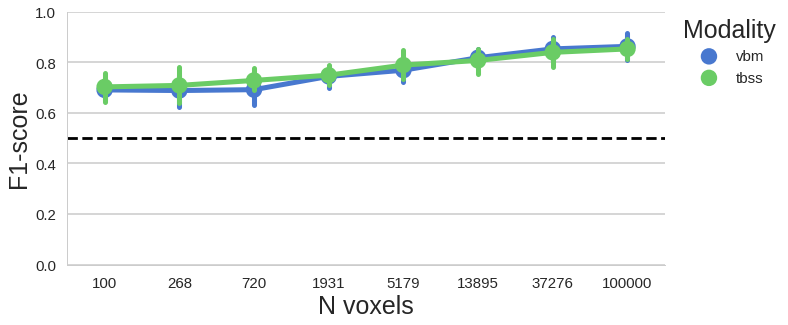

In [197]:
df_sce1 = pd.DataFrame(results_sce1)
with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.factorplot(x='n_vox', y='score', hue='modality', data=df_sce1, size=5, aspect=2, legend_out=False,
                       palette="muted", legend=False)
    g.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.savefig('figures/f1_X_original_gender.pdf', transparent=True, bbox_inches='tight')
    plt.show()

As you can see, performance is far above chance, but it is unclear what drives our results (which is in general a problem in MVPA ...). Let's look at some other scenarios which try to deal with the brain-size confound and check to what extent it drives classification performance.

### Just for fun: does performance increase when combining features?

In [14]:
results_fun = {'n_vox': [], 'score': []}
mini_pipe = Pipeline([('ufs', SelectKBest(f_classif, k=None)),
                      ('scaler', StandardScaler())])
clf = SVC(kernel='linear')
skf = StratifiedKFold(n_splits=10)
for i, nV in enumerate(num_vox):
    print("Evaluating n_vox=%i" % nV)
    
    mini_pipe.set_params(ufs__k=nV)
    
    for train_idx, test_idx in skf.split(mvp['vbm'].X, mvp['vbm'].y):
        mini_pipe.fit(mvp['vbm'].X[train_idx], mvp['vbm'].y[train_idx])
        X_vbm_train = mini_pipe.transform(mvp['vbm'].X[train_idx])
        X_vbm_test = mini_pipe.transform(mvp['vbm'].X[test_idx])
        
        mini_pipe.fit(mvp['tbss'].X[train_idx], mvp['tbss'].y[train_idx])
        X_tbss_train = mini_pipe.transform(mvp['tbss'].X[train_idx])
        X_tbss_test = mini_pipe.transform(mvp['tbss'].X[test_idx])
        
        X_concat_train = np.hstack((X_vbm_train, X_tbss_train))
        X_concat_test = np.hstack((X_vbm_test, X_tbss_test))
        
        clf.fit(X_concat_train, mvp['vbm'].y[train_idx])
        score = clf.score(X_concat_test, mvp['vbm'].y[test_idx])
        results_fun['n_vox'].append(nV)
        results_fun['score'].append(score)

Evaluating n_vox=100
Evaluating n_vox=268
Evaluating n_vox=720
Evaluating n_vox=1931
Evaluating n_vox=5179
Evaluating n_vox=13895
Evaluating n_vox=37276
Evaluating n_vox=100000


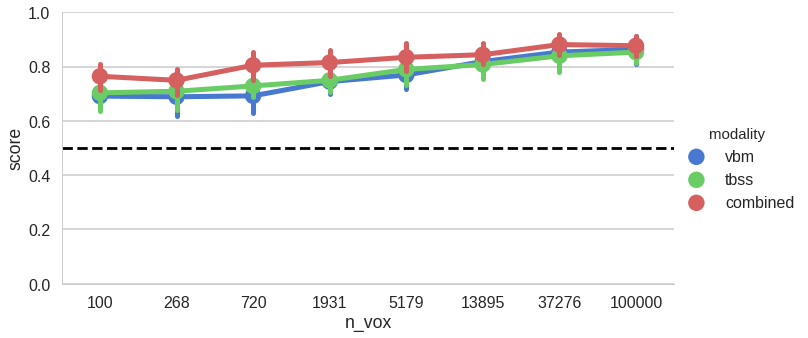

In [110]:
df_fun = pd.DataFrame(results_fun)
df_fun['modality'] = ['combined'] * len(df_fun)
df_combined = pd.concat((df_fun, df_sce1))

with sns.plotting_context("poster"):
    plt.figure(figsize=((9.6, 4.01)))
    g = sns.factorplot(x='n_vox', y='score', hue='modality', data=df_combined, palette='muted',
                       size=5, aspect=2, hue_order=['vbm', 'tbss', 'combined'])
    g.set(ylim=(0, 1))
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.show()

## Scenario 2: confound regression on entire dataset
First, we'll evaluate the strategy that is most often adopted: regressing out the confound from the entire data-set (here: `X`) at once, like we did when we compared the correlation distributions of the voxels and gender/brain-size between "uncorrected" and "corrected" data. 

In the rest of the notebook, we'll discuss and demonstrate different ways of regressing out a confound from the data ("X"), and to reduce the boilerplate code, we wrote a custom `scikit-learn`-style "transformer" class that does exactly this: take a confound upon initialization and subsequently fits a model using the confound to predict each feature in `X` during `fit(X)`, and subsequently regresses out the confound from each feature in `X` during `transform(X)` (in a scikit-learn style). 

For more info on the exact implementation of the `ConfoundRegressor` object, check the [skbold Github repo](https://github.com/lukassnoek/skbold/blob/master/skbold/preproc/confounds.py).

Assuming that the latest version of `skbold` is installed on the system, let's import the `ConfoundRegressor` class.

In [16]:
from skbold.preproc.confounds import ConfoundRegressor

Let's copy the Mvp objects, regress out the confound, and store it in a new dict (`mvp_sce2`).

In [17]:
mvp_sce2 = {}
for modality in ['vbm', 'tbss']:
    print("Processing mod=%s" % modality)
    tmp = deepcopy(mvp[modality])
    con_reg = ConfoundRegressor(confound=confound[modality],
                                fit_idx=range(tmp.X.shape[0]))
    tmp.X = con_reg.fit(tmp.X, tmp.y).transform(tmp.X)
    mvp_sce2[modality] = tmp

Processing mod=vbm
Processing mod=tbss


Now, we'll do exactly the same as in "scenario 1", but this time with the confound-regressed data:

In [18]:
results_sce2 = {'n_vox': [], 'score': [], 'modality': []}

for modality in ['vbm', 'tbss']:
    print("\nProcessing mod=%s" % modality)
    
    for i, nV in enumerate(num_vox):
        print("Evaluating n_vox=%i" % nV)
        
        pipeline.set_params(ufs__k=nV)
        this_mvp = mvp_sce2[modality]
        scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y,
                                 cv=n_folds, scoring=metric, n_jobs=n_jobs)
        results_sce2['n_vox'].extend([nV] * n_folds)
        results_sce2['score'].extend(scores.tolist())
        results_sce2['modality'].extend([modality] * n_folds)


Processing mod=vbm
Evaluating n_vox=100
Evaluating n_vox=268
Evaluating n_vox=720
Evaluating n_vox=1931
Evaluating n_vox=5179
Evaluating n_vox=13895
Evaluating n_vox=37276
Evaluating n_vox=100000

Processing mod=tbss
Evaluating n_vox=100
Evaluating n_vox=268
Evaluating n_vox=720
Evaluating n_vox=1931
Evaluating n_vox=5179
Evaluating n_vox=13895
Evaluating n_vox=37276
Evaluating n_vox=100000


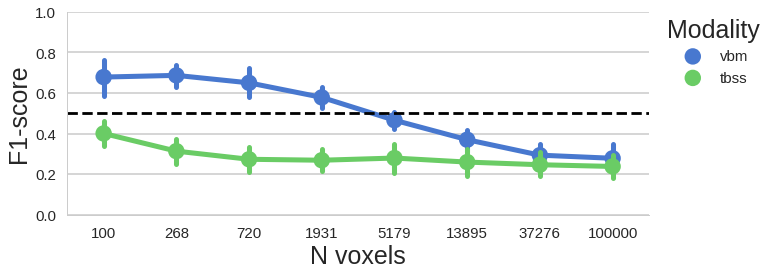

In [201]:
df_sce2 = pd.DataFrame(results_sce2)
with sns.plotting_context(rc=rc):
    ax = sns.factorplot(x='n_vox', y='score', hue='modality', data=df_sce2, size=5, aspect=2, legend_out=False,
                        palette='muted', legend=False)
    ax.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    plt.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.savefig('figures/f1_X_correctedwrong_gender.pdf', transparent=True, bbox_inches='tight')
    plt.show()

**What??** We see that classification performance quickly drops under chance level with an increasing number of voxels in our analyses... As we've shown in our simulations, this is due to the fact that we've regressed out our confound on the *entire data-set (X)*, but then proceed to do K-fold cross-validation, in which (due to sampling error) confounds might still have a (opposite!) effect in train and test. So, naturally, let's check and see what happens when we fit the confound regression on the train-set only and subsequently use those models to regress the confound on the train- *and* test-set. Or in other words, let's cross-validate our confound-regression

## Scenario 3: confound regression on train and cv to test
Because our confound regression is going to take (roughly) `K` times (i.e. the amount of folds) as long, and it is inefficient to regress out our confounds from each fold again for every different number of voxels, we have written a function to parallelize our fold-wise classification by putting in the loop over `num_vox` inside that function.

Note that the `ConfoundRegressor` is initialized with an additional parameter now: `cross_validate=True`, which makes sure that when we transform the test-set, it uses the weights from the fitting procedure on the train-set. (In the next scenario, we'll set `cross_validate` to `False` in order to check what happens when we fit it separately to the test-set.)

In [20]:
def _parallelize_sce3(X, y, c, train_idx, test_idx,
                      pipeline, num_vox, modality, n_folds, i):
    """ Runs a specific fold in K-fold cross-validation for
    a given set num_vox (array with number of voxels to select). """
    
    print("Starting confound regression fold: %i" % (i + 1))
    conreg = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=True)
    X_train_con = conreg.fit(X[train_idx], y).transform(X[train_idx])
    X_test_con = conreg.transform(X[test_idx])
    
    results_tmp = {'score': np.zeros(len(num_vox)),
                   'n_vox': num_vox,
                   'modality': [modality] * len(num_vox),
                   'n_folds': [n_folds] * len(num_vox)}
    
    print("Starting processing fold: %i" % (i + 1))
    for j, nV in enumerate(num_vox):
        pipeline.set_params(ufs__k=nV)
        pipeline.fit(X_train_con, y[train_idx])
        pred = pipeline.predict(X_test_con)
        score = f1_score(y[test_idx], pred)
        results_tmp['score'][j] = score
    
    return results_tmp

It is kinda messy, but below we essentially just do the same thing as in the first two scenarios. This takes quite long, because essentially we're fitting ~400,000 * 10 linear models!

In [21]:
results_sce3 = []

for modality in ['vbm', 'tbss']:
    print("Processing mod=%s" % modality)
    skf = StratifiedKFold(n_splits=n_folds)
    this_mvp = mvp[modality]
    
    res = jl.Parallel(n_jobs=2)(jl.delayed(_parallelize_sce3)
                                (this_mvp.X, this_mvp.y, confound[modality], train_idx,
                                 test_idx, pipeline, num_vox, modality, n_folds, i)
                                 for i, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)))
    results_sce3.append(res)

Processing mod=vbm
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting processing fold: 1
Starting processing fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting processing fold: 3
Starting processing fold: 4
Starting confound regression fold: 5
Starting confound regression fold: 6
Starting processing fold: 5
Starting confound regression fold: 7
Starting processing fold: 6
Starting confound regression fold: 8
Starting processing fold: 7
Starting confound regression fold: 9
Starting processing fold: 8
Starting confound regression fold: 10
Starting processing fold: 9
Starting processing fold: 10
Processing mod=tbss
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting processing fold: 1
Starting processing fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting processing fold: 3
Starting processing fold: 4
Starting confound regression fold: 5
Starting con

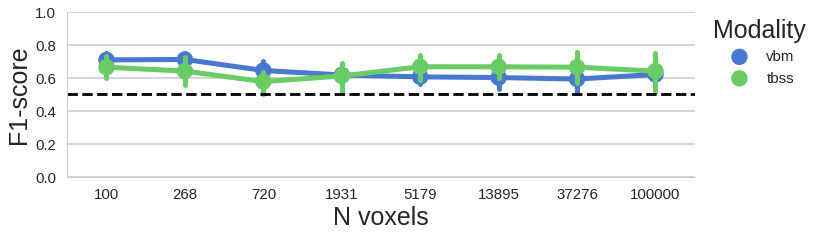

In [202]:
results_sce3_concat = pd.concat([pd.DataFrame(x) for mod_list in results_sce3 for x in mod_list])

with sns.plotting_context(rc=rc):
    g = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce3_concat, size=5, aspect=2,
                       palette='muted', legend=False)
    g.set(ylim=(0, 1), xlabel='N voxels', ylabel='F1-score')
    plt.axhline(y=0.5, c='black', ls='dashed')
    fig = plt.gcf()
    fig.set_size_inches((10.5, 3.25))
    plt.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.savefig('figures/f1_X_correctedright_gender.pdf', transparent=True, bbox_inches='tight')
    plt.show()

As we can see, classification performance stays above chance (for the entire range of number of voxels)! However, one could also argue that, instead of cross-validating our confound-regression, we can also just fit a separate confound-regression on the *test-set*. Because, theoretically, this sets the influence of the confound in the test-set also exactly to zero (like in scenario 1), yet without the danger of opposite effects of the confound in train- and test. (Note, thought, that this danger is, again, likely when doing some kind of inner cross-validation within your analyses, such as when you perform a hyper-parameter gridsearch!)

### Just for fun 2: combining?
FYI: this takes forever.

In [23]:
results_fun2 = {'n_vox': [], 'score': [], 'modality': []}
skf = StratifiedKFold(n_splits=10)
for i, nV in enumerate(num_vox):
    print("Evaluating n_vox=%i" % nV)
    
    mini_pipe.set_params(ufs__k=nV)
    
    for train_idx, test_idx in skf.split(mvp['vbm'].X, mvp['vbm'].y):
        
        conreg = ConfoundRegressor(confound=confound['vbm'], fit_idx=train_idx,
                                   cross_validate=True)
        X_vbm_train = conreg.fit(mvp['vbm'].X[train_idx], mvp['vbm'].y[train_idx]).transform(mvp['vbm'].X[train_idx])
        X_vbm_test = conreg.transform(mvp['vbm'].X[test_idx])
        
        conreg = ConfoundRegressor(confound=confound['tbss'], fit_idx=train_idx,
                                   cross_validate=True)
        X_tbss_train = conreg.fit(mvp['tbss'].X[train_idx], mvp['tbss'].y[train_idx]).transform(mvp['tbss'].X[train_idx])
        X_tbss_test = conreg.transform(mvp['tbss'].X[test_idx])
        
        mini_pipe.fit(X_vbm_train, mvp['vbm'].y[train_idx])
        X_vbm_train = mini_pipe.transform(X_vbm_train)
        X_vbm_test = mini_pipe.transform(X_vbm_test)

        mini_pipe.fit(X_tbss_train, mvp['tbss'].y[train_idx])
        X_tbss_train = mini_pipe.transform(X_tbss_train)
        X_tbss_test = mini_pipe.transform(X_tbss_test)
        
        X_concat_train = np.hstack((X_vbm_train, X_tbss_train))
        X_concat_test = np.hstack((X_vbm_test, X_tbss_test))
        
        clf.fit(X_concat_train, mvp['vbm'].y[train_idx])
        score = clf.score(X_concat_test, mvp['vbm'].y[test_idx])
        results_fun2['n_vox'].append(nV)
        results_fun2['score'].append(score)
        results_fun2['modality'].append('combined')

Evaluating n_vox=100
Evaluating n_vox=268
Evaluating n_vox=720
Evaluating n_vox=1931
Evaluating n_vox=5179
Evaluating n_vox=13895
Evaluating n_vox=37276
Evaluating n_vox=100000


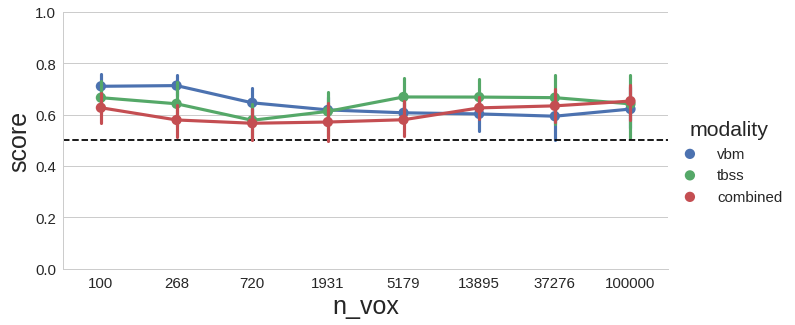

In [24]:
df_fun2 = pd.DataFrame(results_fun2)
df_combined2 = pd.concat((df_fun2, results_sce3_concat))
g = sns.factorplot(x='n_vox', y='score', hue='modality', data=df_combined2,
                   size=5, aspect=2, hue_order=['vbm', 'tbss', 'combined'])
g.set(ylim=(0, 1))
plt.axhline(y=0.5, c='black', ls='dashed')
plt.show()

## Scenario 4: confound regression on train and test separately
Just as in scenario 3, we have written a function to parallelize the fold-wise classification analysis. Note that the only difference with scenario 3 is the fact that the parameter `cross_validate` from the `ConfoundRegressor` is set to `False`. This means that the `ConfoundRegressor` will now fit the confound-regression process again when the `transform(X)` method is called on the test-set (`X[test_idx]`).

In [25]:
def _parallelize_sce4(X, y, c, train_idx, test_idx,
                      pipeline, num_vox, modality, n_folds, i):
    
    print("Starting confound regression fold: %i" % (i + 1))
    conreg = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=False)
    X_train_con = conreg.fit(X[train_idx], y).transform(X[train_idx])
    X_test_con = conreg.transform(X[test_idx])
    
    results_tmp = {'score': np.zeros(len(num_vox)),
                   'n_vox': num_vox,
                   'modality': [modality] * len(num_vox),
                   'n_folds': [n_folds] * len(num_vox)}
    print("Starting processing fold: %i" % (i + 1))
    
    for j, nV in enumerate(num_vox):
        pipeline.set_params(ufs__k=nV)
        pipeline.fit(X_train_con, y[train_idx])
        pred = pipeline.predict(X_test_con)
        score = f1_score(y[test_idx], pred)
        results_tmp['score'][j] = score
    
    return results_tmp

Just like scenario 3, we run the analysis for scenario 4 (this takes forever, though, because we now have to fit :

In [26]:
results_sce4 = []

for modality in ['vbm', 'tbss']:
    print("Processing mod=%s" % modality)
    skf = StratifiedKFold(n_splits=n_folds)
    this_mvp = mvp[modality]
    
    res = jl.Parallel(n_jobs=5)(jl.delayed(_parallelize_sce4)
                                (this_mvp.X, this_mvp.y, confound[modality], train_idx,
                                 test_idx, pipeline, num_vox, modality, n_folds, i)
                                 for i, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)))
    results_sce4.append(res)

Processing mod=vbm
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting confound regression fold: 5
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 1
Starting processing fold: 3
Starting processing fold: 5
Starting processing fold: 4
Starting processing fold: 2
Starting confound regression fold: 6
Starting confound regression fold: 7
Starting confound regression fold: 8
Starting confound regression fold: 9
Starting confound regression fold: 10
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 6
Starting processing fold: 8
Starting processing fold: 9
Starting processing fold: 7
Starting processing fold: 10
Processing mod=tbss
Starting confound regression fold: 1
St

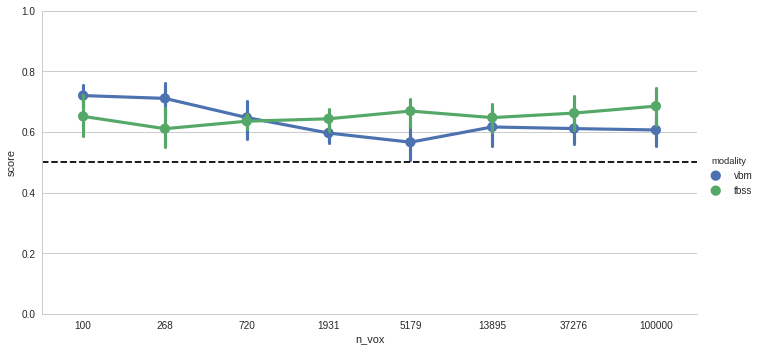

In [27]:
results_sce4_concat = pd.concat([pd.DataFrame(x) for mod_list in results_sce4 for x in mod_list])
sns.set(style="whitegrid")
ax = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce4_concat, size=5, aspect=2)
ax.set(ylim=(0, 1))
plt.axhline(y=0.5, c='black', ls='dashed')

As you can see, the plot for scenario 4 looks very similar to the one for scenario 3. For comparison, be plot them side-by-side below:

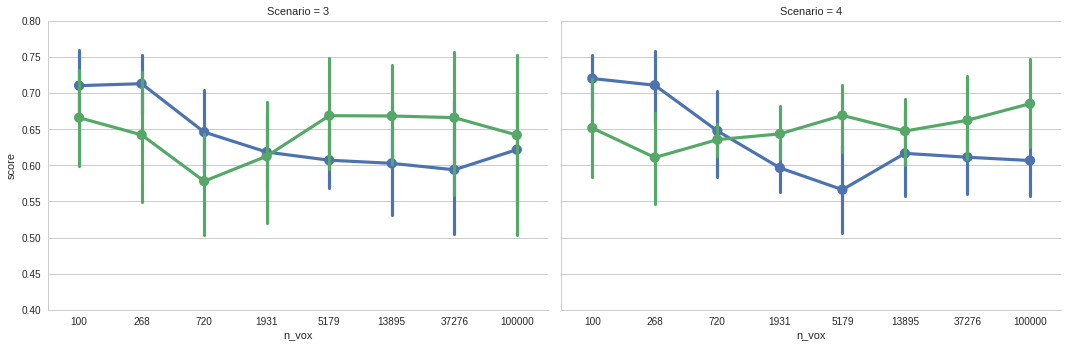

In [28]:
df_sce3 = results_sce3_concat
df_sce3['Scenario'] = ['3'] * len(df_sce3)
df_sce4 = results_sce4_concat
df_sce4['Scenario'] = ['4'] * len(df_sce4)
sce3_sce4_df = pd.concat((df_sce3, df_sce4))

g = sns.FacetGrid(sce3_sce4_df, col="Scenario", hue='modality', ylim=(.4,.8), size=5, aspect=1.5)
g.map(sns.pointplot, "n_vox", "score")

But, one could argue that the efficacy of cross-validation of confound-regression depends on the size of the train-set and/or the size of the test-set. This is what we explore below.

## Test: does the train/test ratio matter?
We simply redo the previous two scenarios but with another loop over number of folds (higher number = larger train/test ratio).

In [29]:
results_ratio_sce3 = []
results_ratio_sce4 = []
kfolds = [2, 4, 8, 16, 32, 64, 100]

for modality in ['vbm', 'tbss']:
    print(modality)
    this_mvp = mvp[modality]
 
    for kfold in kfolds:
        print('Kf=%i' % kfold)
        skf = StratifiedKFold(n_splits=kfold)
    
        res = jl.Parallel(n_jobs=5)(jl.delayed(_parallelize_sce3)
                                    (this_mvp.X, this_mvp.y, confound[modality], train_idx,
                                     test_idx, pipeline, num_vox, modality, kfold, i)
                                     for i, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)))
        
        results_ratio_sce3.append(res)
        
        skf = StratifiedKFold(n_splits=kfold)
        res = jl.Parallel(n_jobs=5)(jl.delayed(_parallelize_sce4)
                                    (this_mvp.X, this_mvp.y, confound[modality], train_idx,
                                     test_idx, pipeline, num_vox, modality, kfold, i)
                                     for i, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)))
        results_ratio_sce4.append(res)

vbm
Kf=2
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting processing fold: 1
Starting processing fold: 2
Starting confound regression fold: 1
Starting confound regression fold: 2
Fitting separately on test
Fitting separately on test
Starting processing fold: 1
Starting processing fold: 2
Kf=4
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting processing fold: 1
Starting processing fold: 2
Starting processing fold: 4
Starting processing fold: 3
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 3
Starting processing fold: 2
Starting processing fold: 4
Starting processing fold: 1
Kf=8
Starting confound regression fold: 1
St

Starting processing fold: 14
Starting processing fold: 13
Starting processing fold: 15
Starting confound regression fold: 16
Starting confound regression fold: 17
Starting confound regression fold: 18
Starting confound regression fold: 19
Starting confound regression fold: 20
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 16
Starting processing fold: 17
Starting processing fold: 19
Starting processing fold: 18
Starting processing fold: 20
Starting confound regression fold: 21
Starting confound regression fold: 22
Starting confound regression fold: 23
Starting confound regression fold: 24
Starting confound regression fold: 25
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 21
Starting processing fold: 22
Starting processing fold: 23
Starting processing fold: 24
St

Starting processing fold: 22
Starting processing fold: 24
Starting processing fold: 25
Starting confound regression fold: 26
Starting confound regression fold: 27
Starting confound regression fold: 28
Starting confound regression fold: 29
Starting confound regression fold: 30
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 26
Starting processing fold: 27
Starting processing fold: 28
Starting processing fold: 29
Starting processing fold: 30
Starting confound regression fold: 31
Starting confound regression fold: 32
Starting confound regression fold: 33
Starting confound regression fold: 34
Starting confound regression fold: 35
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 31
Starting processing fold: 32
Starting processing fold: 34
Starting processing fold: 33
St

Starting confound regression fold: 69
Starting confound regression fold: 70
Starting processing fold: 66
Starting processing fold: 67
Starting processing fold: 68
Starting processing fold: 69
Starting processing fold: 70
Starting confound regression fold: 71
Starting confound regression fold: 72
Starting confound regression fold: 73
Starting confound regression fold: 74
Starting confound regression fold: 75
Starting processing fold: 71
Starting processing fold: 72
Starting processing fold: 73
Starting processing fold: 74
Starting processing fold: 75
Starting confound regression fold: 76
Starting confound regression fold: 77
Starting confound regression fold: 78
Starting confound regression fold: 79
Starting confound regression fold: 80
Starting processing fold: 76
Starting processing fold: 77
Starting processing fold: 78
Starting processing fold: 80
Starting processing fold: 79
Starting confound regression fold: 81
Starting confound regression fold: 82
Starting confound regression fold

Starting processing fold: 62
Starting processing fold: 63
Starting processing fold: 64
Starting processing fold: 65
Starting confound regression fold: 66
Starting confound regression fold: 67
Starting confound regression fold: 68
Starting confound regression fold: 69
Starting confound regression fold: 70
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 66
Starting processing fold: 67
Starting processing fold: 68
Starting processing fold: 69
Starting processing fold: 70
Starting confound regression fold: 71
Starting confound regression fold: 72
Starting confound regression fold: 73
Starting confound regression fold: 74
Starting confound regression fold: 75
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 71
Starting processing fold: 72
Starting processing fold: 73
St

Starting confound regression fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting confound regression fold: 5
Starting processing fold: 1
Starting processing fold: 2
Starting processing fold: 3
Starting processing fold: 5
Starting processing fold: 4
Starting confound regression fold: 6
Starting confound regression fold: 7
Starting confound regression fold: 8
Starting confound regression fold: 9
Starting confound regression fold: 10
Starting processing fold: 7
Starting processing fold: 6
Starting processing fold: 8
Starting processing fold: 9
Starting processing fold: 10
Starting confound regression fold: 11
Starting confound regression fold: 12
Starting confound regression fold: 13
Starting confound regression fold: 14
Starting confound regression fold: 15
Starting processing fold: 12
Starting processing fold: 11
Starting processing fold: 14
Starting processing fold: 13
Starting processing fold: 15
Starting confound regression fold: 16
Starting con

Starting confound regression fold: 49
Starting confound regression fold: 50
Starting processing fold: 46
Starting processing fold: 47
Starting processing fold: 48
Starting processing fold: 49
Starting processing fold: 50
Starting confound regression fold: 51
Starting confound regression fold: 52
Starting confound regression fold: 53
Starting confound regression fold: 54
Starting confound regression fold: 55
Starting processing fold: 51
Starting processing fold: 52
Starting processing fold: 53
Starting processing fold: 54
Starting processing fold: 55
Starting confound regression fold: 56
Starting confound regression fold: 57
Starting confound regression fold: 58
Starting confound regression fold: 59
Starting confound regression fold: 60
Starting processing fold: 56
Starting processing fold: 58
Starting processing fold: 59
Starting processing fold: 57
Starting processing fold: 60
Starting confound regression fold: 61
Starting confound regression fold: 62
Starting confound regression fold

Starting confound regression fold: 18
Starting confound regression fold: 19
Starting confound regression fold: 20
Starting processing fold: 16
Starting processing fold: 17
Starting processing fold: 18
Starting processing fold: 19
Starting processing fold: 20
Starting confound regression fold: 21
Starting confound regression fold: 22
Starting confound regression fold: 23
Starting confound regression fold: 24
Starting confound regression fold: 25
Starting processing fold: 21
Starting processing fold: 22
Starting processing fold: 23
Starting processing fold: 24
Starting processing fold: 25
Starting confound regression fold: 26
Starting confound regression fold: 27
Starting confound regression fold: 28
Starting confound regression fold: 29
Starting confound regression fold: 30
Starting processing fold: 27
Starting processing fold: 26
Starting processing fold: 28
Starting processing fold: 29
Starting processing fold: 30
Starting confound regression fold: 31
Starting confound regression fold

Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 26
Starting processing fold: 27
Starting processing fold: 28
Starting processing fold: 29
Starting processing fold: 30
Starting confound regression fold: 31
Starting confound regression fold: 32
Starting confound regression fold: 33
Starting confound regression fold: 34
Starting confound regression fold: 35
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Starting processing fold: 31
Starting processing fold: 32
Starting processing fold: 33
Starting processing fold: 34
Starting processing fold: 35
Starting confound regression fold: 36
Starting confound regression fold: 37
Starting confound regression fold: 38
Starting confound regression fold: 39
Starting confound regression fold: 40
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fitting separately on test
Fittin

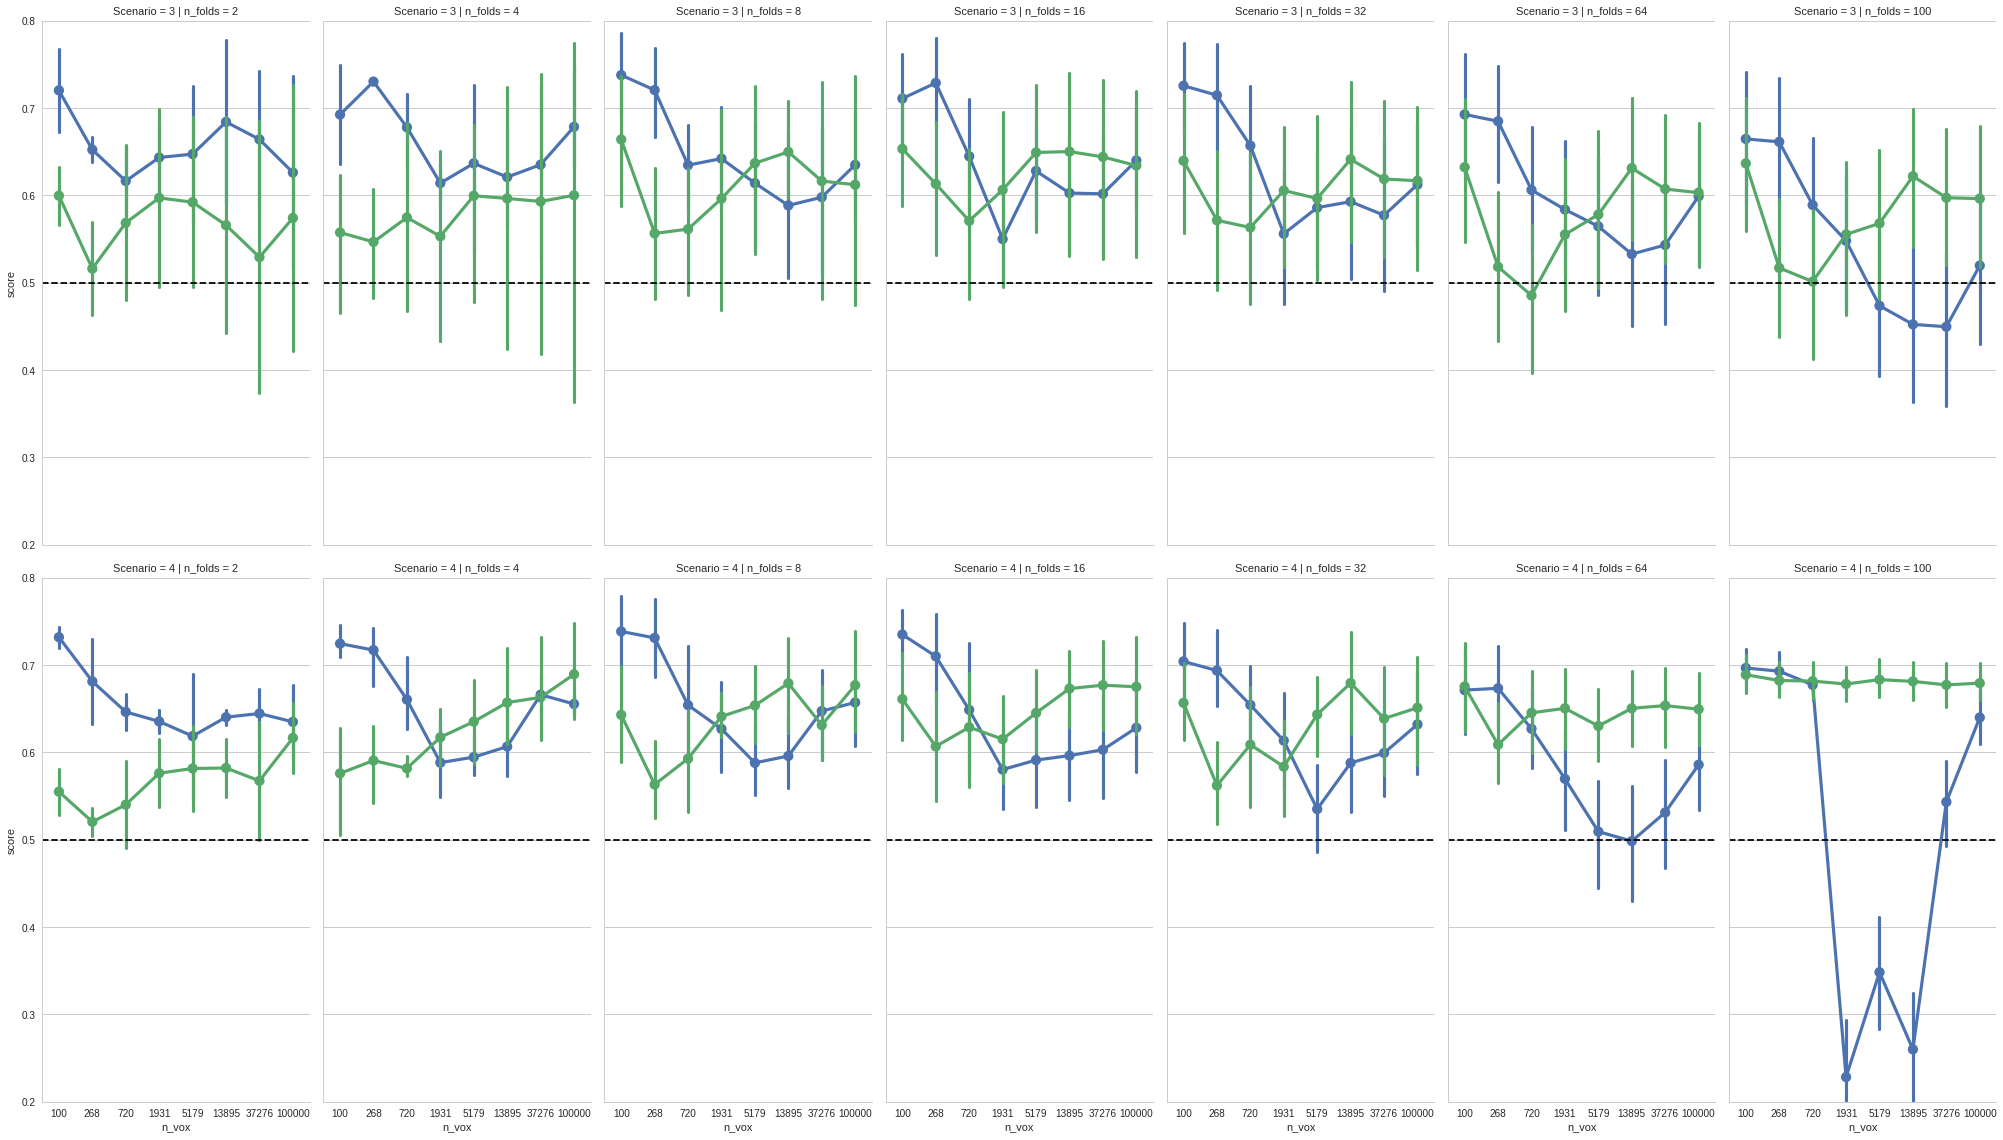

In [30]:
results_ratio_sce3_concat = pd.concat([pd.DataFrame(x) for mod_list in results_ratio_sce3 for x in mod_list])
results_ratio_sce3_concat['Scenario'] = ['3'] * len(results_ratio_sce3_concat)
results_ratio_sce4_concat = pd.concat([pd.DataFrame(x) for mod_list in results_ratio_sce4 for x in mod_list])
results_ratio_sce4_concat['Scenario'] = ['4'] * len(results_ratio_sce4_concat)
all_results_ratio = pd.concat((results_ratio_sce3_concat, results_ratio_sce4_concat))
g = sns.FacetGrid(all_results_ratio, col="n_folds", row="Scenario", hue='modality', ylim=(0.2,.8), size=8, aspect=0.5)
g.map(sns.pointplot, "n_vox", "score")

for ax in g.axes.ravel():
    ax.axhline(0.5, ls='dashed', c='black')

## Scenario 5: only regress confound out of train
Since the model is only fitted on the train-set, and thus the model cannot learn brain-size related information, one could argue that we don't need to do anything to the test-set...

In [31]:
def _parallelize_sce5(X, y, c, train_idx, test_idx,
                      pipeline, num_vox, modality, n_folds, i):
    
    print("Starting confound regression fold: %i" % (i + 1))
    conreg = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=False)
    X_train_con = conreg.fit(X[train_idx], y).transform(X[train_idx])
    
    results_tmp = {'score': np.zeros(len(num_vox)),
                   'n_vox': num_vox,
                   'modality': [modality] * len(num_vox),
                   'n_folds': [n_folds] * len(num_vox)}
    
    print("Starting processing fold: %i" % (i + 1))
    
    for j, nV in enumerate(num_vox):
        pipeline.set_params(ufs__k=nV)
        pipeline.fit(X_train_con, y[train_idx])
        pred = pipeline.predict(X[test_idx])
        score = f1_score(y[test_idx], pred)
        results_tmp['score'][j] = score
    
    return results_tmp

In [32]:
results_sce5 = []

for modality in ['vbm', 'tbss']:
    print("Processing mod=%s" % modality)
    skf = StratifiedKFold(n_splits=n_folds)
    this_mvp = mvp[modality]
    
    res = jl.Parallel(n_jobs=6)(jl.delayed(_parallelize_sce5)
                                (this_mvp.X, this_mvp.y, confound[modality], train_idx,
                                 test_idx, pipeline, num_vox, modality, n_folds, i)
                                 for i, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)))
    results_sce5.append(res)

Processing mod=vbm
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting confound regression fold: 5
Starting confound regression fold: 6
Starting processing fold: 1
Starting processing fold: 2
Starting processing fold: 3
Starting processing fold: 4
Starting processing fold: 5
Starting processing fold: 6
Starting confound regression fold: 7
Starting confound regression fold: 8
Starting confound regression fold: 9
Starting confound regression fold: 10
Starting processing fold: 7
Starting processing fold: 9
Starting processing fold: 8
Starting processing fold: 10
Processing mod=tbss
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting confound regression fold: 5
Starting confound regression fold: 6
Starting processing fold: 1
Starting processing fold: 2
Starting processing fold: 3
Sta

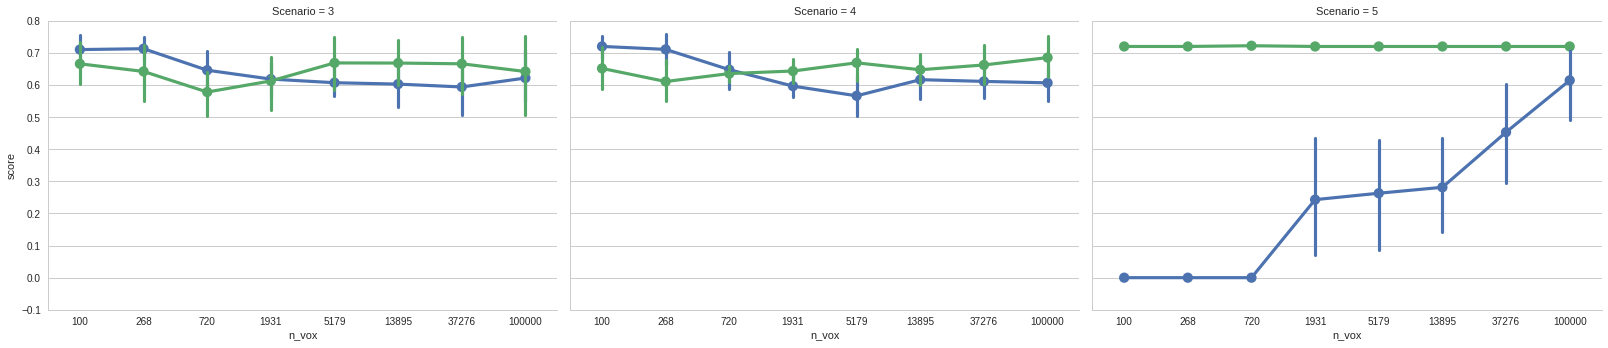

In [34]:
df_sce5 = pd.concat([pd.DataFrame(x) for mod_list in results_sce5 for x in mod_list])
df_sce5['Scenario'] = ['5'] * len(df_sce5)
sce3_sce4_sce5_df = pd.concat((sce3_sce4_df, df_sce5))
g = sns.FacetGrid(sce3_sce4_sce5_df, col="Scenario", hue='modality', ylim=(.4,.8), size=5, aspect=1.5)
g.map(sns.pointplot, "n_vox", "score")
g.set(ylim=(-.1, 0.8))

## Scenario 5: inverse probability weighting
Using the IPW-SVM algorithm described by Linn et al. Not yet working ...

### Baseline (no IPW, K=5179, n_folds=10)

In [ ]:
from sklearn.linear_model import LogisticRegression

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)
f1_scores = []
    
logreg = LogisticRegression(class_weight='balanced', C=1)
this_K = 5179
C = [0.001, 0.01, 0.1, 1, 10, 100]
ipw_sce = ['yes', 'no']

results_sce5 = {'scores': [], 'modality': [], 'C': [], 'ipw': []}

for modality in ['vbm', 'tbss']:
    print(modality)
    this_mvp = mvp[modality]
    this_confound = confound[modality]
    this_pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=this_K)),
                              ('scaler', StandardScaler()),
                              ('clf', SVC(kernel='rbf'))])
    this_confound = (this_confound - this_confound.mean()) / this_confound.std()
    this_confound = this_confound[:, np.newaxis]
    logreg.fit(this_confound, this_mvp.y)
    ipw = 1.0/(this_mvp.y - logreg.predict_proba(this_confound)[:, 1]) ** 2
    
    for c_val in C:
        print("C=%.3f" % c_val)
        this_pipeline.set_params(clf__C=c_val)
        for do_ipw in ipw_sce:
            results_sce5['ipw'].extend([do_ipw] * n_folds)
            if do_ipw == 'yes':
                scores = cross_val_score(this_pipeline, this_mvp.X, this_mvp.y, scoring=metric,
                                         cv=skf, fit_params={'clf__sample_weight': ipw}, n_jobs=5)
            else:
                scores = cross_val_score(this_pipeline, this_mvp.X, this_mvp.y, scoring=metric,
                                         cv=skf, n_jobs=5)
            results_sce5['scores'].extend(scores)
            results_sce5['modality'].extend([modality] * n_folds)
            results_sce5['C'].extend([c_val] * n_folds)

In [ ]:
results_sce5_df = pd.DataFrame(results_sce5)
g = sns.FacetGrid(results_sce5_df, col="ipw",hue='modality', ylim=(0 ,1), size=8, aspect=0.5)
g.map(sns.pointplot, "C", "scores")